In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
!unzip '/content/drive/MyDrive/ML Project - Dump/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_v

In [ ]:
# from https://www.astrobetter.com/blog/2010/03/03/fourier-transforms-of-images-in-python/
import numpy as np

import numpy as np
import cv2
import os
import pickle
from scipy.fftpack import dct  # Import the DCT function
from scipy.interpolate import griddata


def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is
             None, which then uses the center of the image (including
             fractional pixels).

    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin

    # Calculate the cumulative sum, checking for non-zero denominators
    csim = np.cumsum(i_sorted, dtype=float)
    nonzero_nr = nr > 0  # Check for non-zero denominators
    tbin = np.zeros_like(nr, dtype=float)
    tbin[nonzero_nr] = csim[rind[1:]][nonzero_nr] - csim[rind[:-1]][nonzero_nr]

    # Avoid division by zero by setting the result to zero where nr is zero
    radial_prof = np.zeros_like(tbin, dtype=float)
    radial_prof[nonzero_nr] = tbin[nonzero_nr] / nr[nonzero_nr]

    return radial_prof

In [ ]:
import numpy as np
from skimage import feature

def compute_LBP(image, radius=1, n_points=8):
    """
    Compute the Local Binary Pattern (LBP) for each pixel in the image.

    image - The 2D grayscale image
    radius - Radius for LBP calculation
    n_points - Number of points in LBP
    """
    lbp_image = feature.local_binary_pattern(image, n_points, radius, method='uniform')
    return lbp_image

def azimuthalAverage_LBP(image, center=None, radius=1, n_points=8):
    """
    Calculate the azimuthally averaged LBP profile.

    image - The 2D grayscale image
    center - The [x,y] pixel coordinates used as the center. The default is
             None, which then uses the center of the image (including
             fractional pixels).
    radius - Radius for LBP calculation
    n_points - Number of points in LBP
    """
    if center is None:
        center = np.array([(image.shape[1] - 1) / 2, (image.shape[0] - 1) / 2])

    lbp_image = compute_LBP(image, radius, n_points)

    y, x = np.indices(image.shape)
    r = np.hypot(x - center[0], y - center[1]).astype(int)

    max_radius = int(r.max())
    profile = np.zeros(max_radius + 1)

    for i in range(max_radius + 1):
        mask = (r == i)
        profile[i] = np.mean(lbp_image[mask])

    return profile


In [ ]:
import cv2
import numpy as np
import os
# import radialProfile
import glob
from matplotlib import pyplot as plt
import pickle
from scipy.interpolate import griddata

data= {}
epsilon = 1e-8
N = 300
y = []
error = []


number_iter = 1600

psd1D_total = np.zeros([number_iter, N])
label_total = np.zeros([number_iter])
psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)


cont = 0

#fake data
rootdir = '/content/real_vs_fake/real-vs-fake/train/fake/'

for subdir, dirs, files in os.walk(rootdir):
    for file in files:

        filename = os.path.join(subdir, file)

        img = cv2.imread(filename,0)

        # we crop the center
        h = int(img.shape[0]/3)
        w = int(img.shape[1]/3)
        img = img[h:-h,w:-w]

        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)

        magnitude_spectrum = 20*np.log(np.abs(fshift))
        psd1D = azimuthalAverage(magnitude_spectrum)

        # Calculate the azimuthally averaged 1D power spectrum
        points = np.linspace(0,N,num=psd1D.size) # coordinates of a
        xi = np.linspace(0,N,num=N) # coordinates for interpolation

        interpolated = griddata(points,psd1D,xi,method='cubic')
        interpolated /= interpolated[0]

        psd1D_total[cont,:] = interpolated
        label_total[cont] = 0
        cont+=1

        if cont == number_iter:
            break
    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean[x] = np.mean(psd1D_total[:,x])
    psd1D_org_std[x]= np.std(psd1D_total[:,x])


## real data
psd1D_total2 = np.zeros([number_iter, N])
label_total2 = np.zeros([number_iter])
psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)


cont = 0
rootdir2 = '/content/real_vs_fake/real-vs-fake/train/real/'

for subdir, dirs, files in os.walk(rootdir2):
    for file in files:

        filename = os.path.join(subdir, file)
        parts = filename.split("/")

        img = cv2.imread(filename,0)

        # we crop the center
        h = int(img.shape[0]/3)
        w = int(img.shape[1]/3)
        img = img[h:-h,w:-w]

        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        fshift += epsilon


        magnitude_spectrum = 20*np.log(np.abs(fshift))

        # Calculate the azimuthally averaged 1D power spectrum
        psd1D = azimuthalAverage(magnitude_spectrum)

        points = np.linspace(0,N,num=psd1D.size) # coordinates of a
        xi = np.linspace(0,N,num=N) # coordinates for interpolation

        interpolated = griddata(points,psd1D,xi,method='cubic')
        interpolated /= interpolated[0]

        psd1D_total2[cont,:] = interpolated
        label_total2[cont] = 1
        cont+=1

        if cont == number_iter:
            break
    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])


y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)

error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((label_total,label_total2), axis=0)

data["data"] = psd1D_total_final
data["label"] = label_total_final

output = open('train_3200.pkl', 'wb')
pickle.dump(data, output)
output.close()

print("DATA Saved")


DATA Saved


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# load feature file
pkl_file = open('train_3200.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

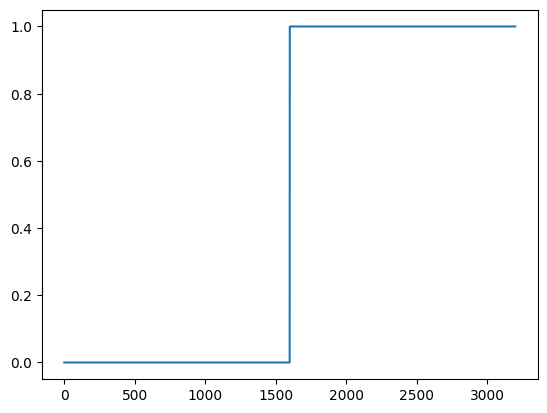

In [ ]:
plt.plot(y)

Text(0, 0.5, 'Power Spectrum')

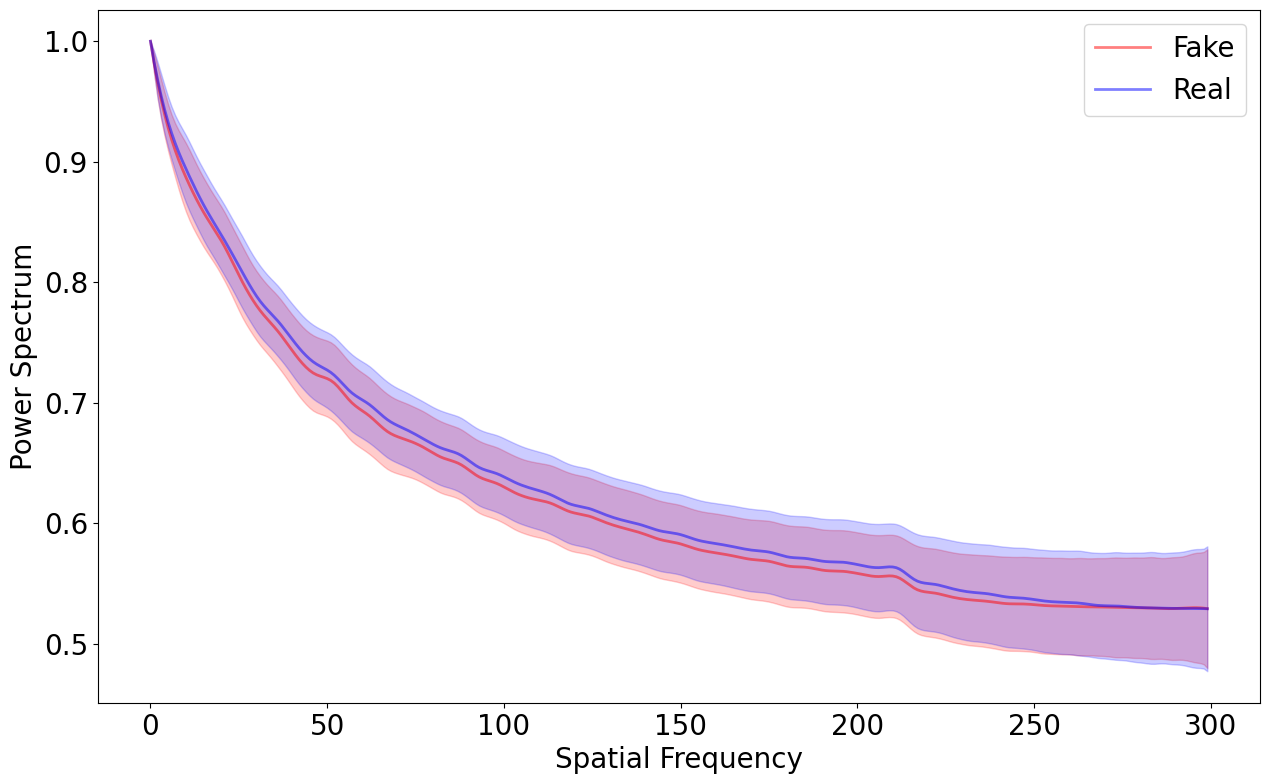

In [ ]:
num = int(X.shape[0]/2)
num_feat = X.shape[1]

psd1D_org_0 = np.zeros((num,num_feat))
psd1D_org_1 = np.zeros((num,num_feat))
psd1D_org_0_mean = np.zeros(num_feat)
psd1D_org_0_std = np.zeros(num_feat)
psd1D_org_1_mean = np.zeros(num_feat)
psd1D_org_1_std = np.zeros(num_feat)

cont_0=0
cont_1=0

# We separate real and fake using the label
for x in range(X.shape[0]):
    if y[x]==0:
        psd1D_org_0[cont_0,:] = X[x,:]
        cont_0+=1
    elif y[x]==1:
        psd1D_org_1[cont_1,:] = X[x,:]
        cont_1+=1

# We compute statistcis
for x in range(num_feat):
    psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
    psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
    psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
    psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])

# Plot
x = np.arange(0, num_feat, 1)
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='red', label='Fake', linewidth =2.0)
ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='red', alpha=0.2)
ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='blue', label='Real', linewidth =2.0)
ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='blue', alpha=0.2)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("Spatial Frequency", fontsize=20)
plt.ylabel("Power Spectrum", fontsize=20)

In [ ]:
import cv2
import numpy as np
import os
# import radialProfile
import glob
from matplotlib import pyplot as plt
import pickle
from scipy.interpolate import griddata

data= {}
epsilon = 1e-8
N = 300
y = []
error = []
def apply_exponential_transform(data):
    # Applying an exponential transformation
    return np.exp(data)

number_iter = 1600

psd1D_total = np.zeros([number_iter, N])
label_total = np.zeros([number_iter])
psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)


cont = 0

#fake data
rootdir = '/content/real_vs_fake/real-vs-fake/train/fake/'

for subdir, dirs, files in os.walk(rootdir):
    for file in files:

        filename = os.path.join(subdir, file)

        img = cv2.imread(filename,0)

        # we crop the center
        h = int(img.shape[0]/3)
        w = int(img.shape[1]/3)
        img = img[h:-h,w:-w]

        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)

        magnitude_spectrum = 20*np.log(np.abs(fshift))
        exp_magnitude_spectrum = apply_exponential_transform(magnitude_spectrum)

        # Then proceed with azimuthal averaging
        psd1D = azimuthalAverage(exp_magnitude_spectrum)

        # Calculate the azimuthally averaged 1D power spectrum
        points = np.linspace(0,N,num=psd1D.size) # coordinates of a
        xi = np.linspace(0,N,num=N) # coordinates for interpolation

        interpolated = griddata(points,psd1D,xi,method='cubic')
        if interpolated[0] > 1e-8:
            interpolated /= interpolated[0]
        else:
            # Handle the case where interpolated[0] is too small or zero
            # You can choose to set 'interpolated' to a default value or perform another operation
            interpolated = np.zeros_like(interpolated)

        psd1D_total[cont,:] = interpolated
        label_total[cont] = 0
        cont+=1

        if cont == number_iter:
            break
    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean[x] = np.mean(psd1D_total[:,x])
    psd1D_org_std[x]= np.std(psd1D_total[:,x])


## real data
psd1D_total2 = np.zeros([number_iter, N])
label_total2 = np.zeros([number_iter])
psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)


cont = 0
rootdir2 = '/content/real_vs_fake/real-vs-fake/train/real/'

for subdir, dirs, files in os.walk(rootdir2):
    for file in files:

        filename = os.path.join(subdir, file)
        parts = filename.split("/")

        img = cv2.imread(filename,0)

        # we crop the center
        h = int(img.shape[0]/3)
        w = int(img.shape[1]/3)
        img = img[h:-h,w:-w]

        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        fshift += epsilon


        magnitude_spectrum = 20*np.log(np.abs(fshift))

        exp_magnitude_spectrum = apply_exponential_transform(magnitude_spectrum)

        # Then proceed with azimuthal averaging
        psd1D = azimuthalAverage(exp_magnitude_spectrum)
        points = np.linspace(0,N,num=psd1D.size) # coordinates of a
        xi = np.linspace(0,N,num=N) # coordinates for interpolation

        interpolated = griddata(points,psd1D,xi,method='cubic')
        # Ensure the first element is not zero or too small before dividing
        if interpolated[0] > 1e-8:
            interpolated /= interpolated[0]
        else:
            # Handle the case where interpolated[0] is too small or zero
            # You can choose to set 'interpolated' to a default value or perform another operation
            interpolated = np.zeros_like(interpolated)


        psd1D_total2[cont,:] = interpolated
        label_total2[cont] = 1
        cont+=1

        if cont == number_iter:
            break
    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])


y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)

error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((label_total,label_total2), axis=0)

data["data"] = psd1D_total_final
data["label"] = label_total_final

output = open('train_3200_log.pkl', 'wb')
pickle.dump(data, output)
output.close()

print("DATA Saved")


DATA Saved


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# load feature file
pkl_file = open('train_3200_log.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

Text(0, 0.5, 'Power Spectrum')

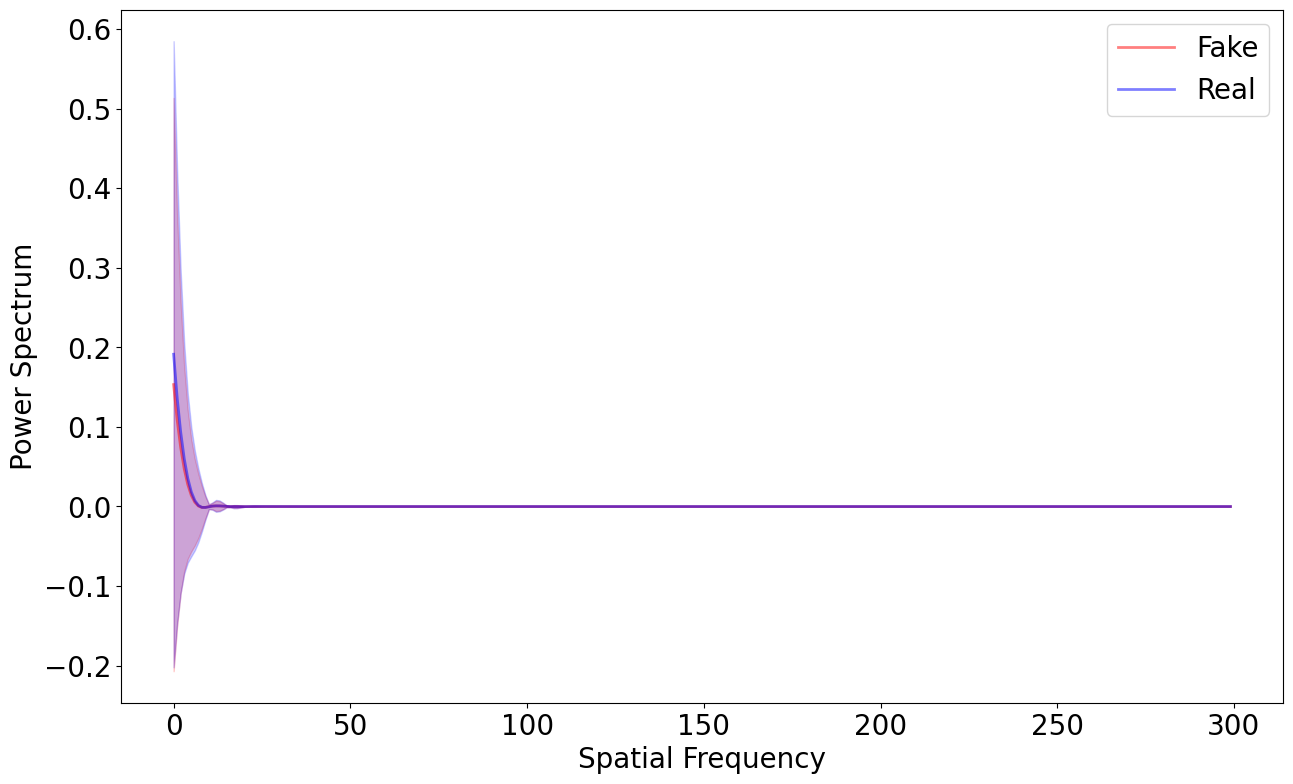

In [ ]:
num = int(X.shape[0]/2)
num_feat = X.shape[1]

psd1D_org_0 = np.zeros((num,num_feat))
psd1D_org_1 = np.zeros((num,num_feat))
psd1D_org_0_mean = np.zeros(num_feat)
psd1D_org_0_std = np.zeros(num_feat)
psd1D_org_1_mean = np.zeros(num_feat)
psd1D_org_1_std = np.zeros(num_feat)

cont_0=0
cont_1=0

# We separate real and fake using the label
for x in range(X.shape[0]):
    if y[x]==0:
        psd1D_org_0[cont_0,:] = X[x,:]
        cont_0+=1
    elif y[x]==1:
        psd1D_org_1[cont_1,:] = X[x,:]
        cont_1+=1

# We compute statistcis
for x in range(num_feat):
    psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
    psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
    psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
    psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])

# Plot
x = np.arange(0, num_feat, 1)
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='red', label='Fake', linewidth =2.0)
ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='red', alpha=0.2)
ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='blue', label='Real', linewidth =2.0)
ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='blue', alpha=0.2)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("Spatial Frequency", fontsize=20)
plt.ylabel("Power Spectrum", fontsize=20)